In [ ]:
root_dir ="/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/"

In [ ]:
import torch
import torch.nn as nn
from torch.nn import MultiheadAttention
from collections import OrderedDict
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import torch.optim as optim
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch.fft as fft

In [ ]:
seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
dataset_root_dir = root_dir + 'DeepfakeEmpiricalStudy/dataset/'
temp_dataset_root_dir = root_dir + 'dataset_small/'
train_dir = dataset_root_dir + 'FSNT/train'
val_dir = dataset_root_dir + 'FSNT/val'

models_root_dir = root_dir + 'DeepfakeEmpiricalStudy_Models/'

In [ ]:
batch_size = 64
num_epochs = 5
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, in_features, hidden_features, dropout_prob):
        super(MLPBlock, self).__init__()
        self.add_module('linear_1', nn.Linear(in_features, hidden_features, bias=True))
        self.add_module('1', nn.GELU(approximate='none'))
        self.add_module('2', nn.Dropout(dropout_prob))
        self.add_module('linear_2', nn.Linear(hidden_features, in_features, bias=True))
        self.add_module('4', nn.Dropout(dropout_prob))

    def forward(self, x):
        for layer in self.children():
            x = layer(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_hidden_dim, dropout_prob):
        super(EncoderBlock, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.self_attention = MultiheadAttention(embed_dim, num_heads, dropout=dropout_prob, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.ln_2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = MLPBlock(embed_dim, mlp_hidden_dim, dropout_prob)

    def forward(self, x):
        attn_output, _ = self.self_attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.ln_1(x)
        mlp_output = self.mlp(x)
        x = x + self.dropout(mlp_output)
        x = self.ln_2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, embed_dim, num_layers, num_heads, mlp_hidden_dim, dropout_prob, num_patches):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)

        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        layers = OrderedDict()
        for i in range(num_layers):
            layers[f'encoder_layer_{i}'] = EncoderBlock(embed_dim, num_heads, mlp_hidden_dim, dropout_prob)

        self.layers = nn.Sequential(layers)
        self.ln = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x):
        x = x + self.pos_embedding
        x = self.dropout(x)
        x = self.layers(x)
        x = self.ln(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000, embed_dim=768, num_layers=12, num_heads=12, mlp_hidden_dim=3072, dropout_prob=0.0):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.conv_proj = nn.Conv2d(in_channels, embed_dim, kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size))

        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.encoder = Encoder(embed_dim, num_layers, num_heads, mlp_hidden_dim, dropout_prob, self.num_patches)

        self.heads = nn.Sequential(OrderedDict([('head', nn.Linear(embed_dim, num_classes))]))

    def forward(self, x):

        x = self.conv_proj(x)  # Shape [batch_size, embed_dim, num_patches_height, num_patches_width]
        x = x.flatten(2)  # Shape [batch_size, embed_dim, num_patches]
        x = x.transpose(1, 2)  # Shape [batch_size, num_patches, embed_dim]

        batch_size = x.size(0)
        class_token = self.class_token.expand(batch_size, -1, -1)  # Shape [batch_size, 1, embed_dim]
        x = torch.cat((class_token, x), dim=1)  # Shape [batch_size, num_patches + 1, embed_dim]

        x = self.encoder(x)
        x = x[:, 0]
        x = self.heads(x)
        return x


model = VisionTransformer(num_classes=2).to(device)
vit_weights = torch.load(models_root_dir + 'vit_b_16-c867db91.pth')
model_state_dict = model.state_dict()
layers_to_load = list(model_state_dict.keys())[:-2]

<ipython-input-6-377c6b1e8565>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_weights = torch.load(models_root_dir + 'vit_b_16-c867db91.pth')


In [ ]:
filtered_weights = {k: v for k, v in vit_weights.items() if k in layers_to_load}
filtered_weights = {k: v for k, v in filtered_weights.items() if k in model_state_dict}
model.load_state_dict(filtered_weights, strict=False)

_IncompatibleKeys(missing_keys=['heads.head.weight', 'heads.head.bias'], unexpected_keys=[])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def evaluate_model(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct / total, np.array(all_labels), np.array(all_preds)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    best_acc = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, criterion)[0]

        print("Epoch "+str(epoch+1)+", Loss: "+str(running_loss/total)+", Train Accuracy: "+str(train_acc)+", Val Accuracy: "+str(val_acc))

        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), models_root_dir + 'best_trained_model.pth')
            print('Model saved!')

    print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

100%|██████████| 63/63 [05:31<00:00,  5.26s/it]


Epoch 1, Loss: 0.7336550655364991, Train Accuracy: 0.4925, Val Accuracy: 0.5
Model saved!


100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


Epoch 2, Loss: 0.6980752873420716, Train Accuracy: 0.51325, Val Accuracy: 0.5


100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


Epoch 3, Loss: 0.6991373362541199, Train Accuracy: 0.5075, Val Accuracy: 0.5


100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


Epoch 4, Loss: 0.6948809204101563, Train Accuracy: 0.49625, Val Accuracy: 0.5


100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


Epoch 5, Loss: 0.6952729368209839, Train Accuracy: 0.4915, Val Accuracy: 0.5005
Model saved!
Training complete. Best validation accuracy: 0.5005


# **Testing**

In [ ]:
test_dirs = [dataset_root_dir + 'FS/test', dataset_root_dir + 'NT/test']

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))

all_labels_combined = []
all_preds_combined = []

for test_dir in test_dirs:
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    test_acc, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
    print(f"Test Accuracy for {test_dir}: {test_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plot_confusion_matrix(cm, classes=['real', 'fake'], title=f'Confusion Matrix for {test_dir}')

    all_labels_combined.extend(all_labels)
    all_preds_combined.extend(all_preds)

cm_combined = confusion_matrix(all_labels_combined, all_preds_combined, labels=[0, 1])
print(f"Average Accuracy: {np.mean([evaluate_model(model, DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=batch_size, shuffle=False), criterion)[0] for test_dir in test_dirs]):.4f}")
plot_confusion_matrix(cm_combined, classes=['real', 'fake'], title='Combined Confusion Matrix')

# **Testing on Unseen datasets**

In [ ]:
test_dirs = [temp_dataset_root_dir + 'CELEB/val', temp_dataset_root_dir + 'DF/test', temp_dataset_root_dir + 'DFD/test', \
             temp_dataset_root_dir + 'F2F/val' ]

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))

all_labels_combined = []
all_preds_combined = []

for test_dir in test_dirs:
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    test_acc, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
    print(f"Test Accuracy for {test_dir}: {test_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plot_confusion_matrix(cm, classes=['real', 'fake'], title=f'Confusion Matrix for {test_dir}')

    all_labels_combined.extend(all_labels)
    all_preds_combined.extend(all_preds)

cm_combined = confusion_matrix(all_labels_combined, all_preds_combined, labels=[0, 1])
print(f"Average Accuracy: {np.mean([evaluate_model(model, DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=batch_size, shuffle=False), criterion)[0] for test_dir in test_dirs]):.4f}")
plot_confusion_matrix(cm_combined, classes=['real', 'fake'], title='Combined Confusion Matrix')

# **Explainability**

In [ ]:
!pip install captum --quiet

In [ ]:
model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))

<ipython-input-10-559b6e824e13>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(models_root_dir + 'best_trained_model.pth'))


<All keys matched successfully>

<ipython-input-11-82a3a0363461>:6: RuntimeWarning: invalid value encountered in divide
  cam_output = (cam_output - cam_output.min()) / (cam_output.max() - cam_output.min())  # Normalize
<ipython-input-11-82a3a0363461>:9: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)


torch.Size([3, 224, 224])


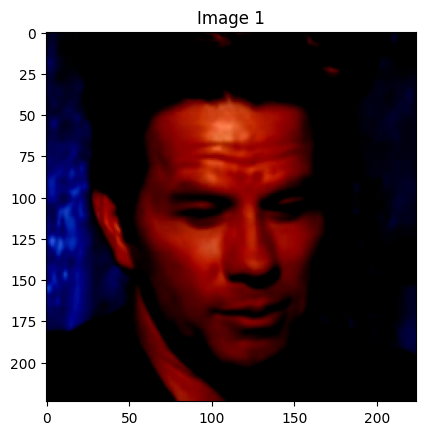

torch.Size([3, 224, 224])


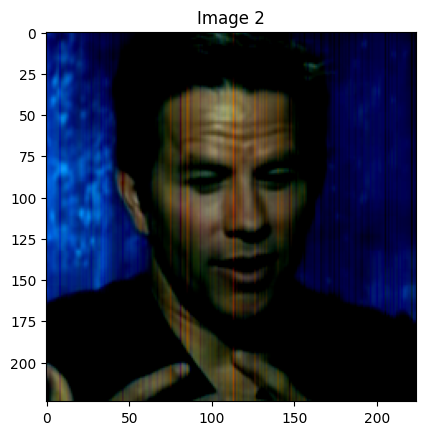

torch.Size([3, 224, 224])


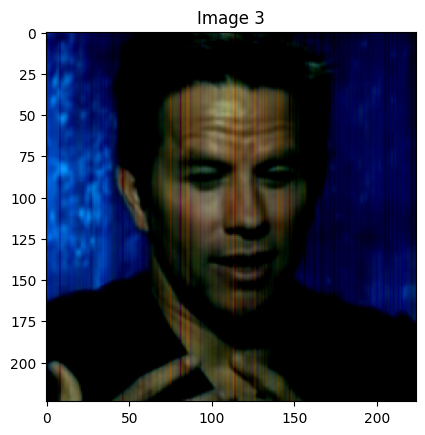

torch.Size([3, 224, 224])


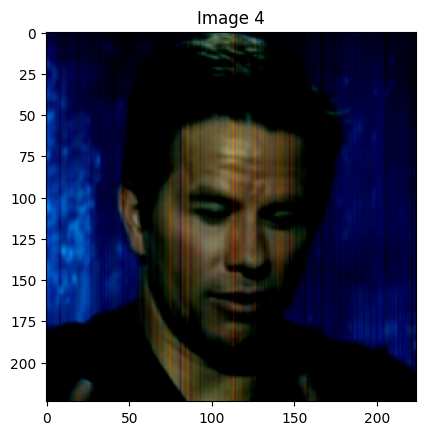

torch.Size([3, 224, 224])


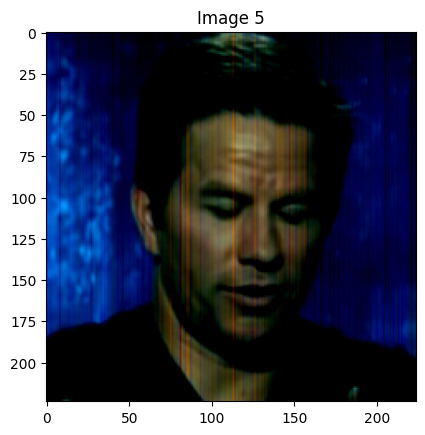

torch.Size([3, 224, 224])


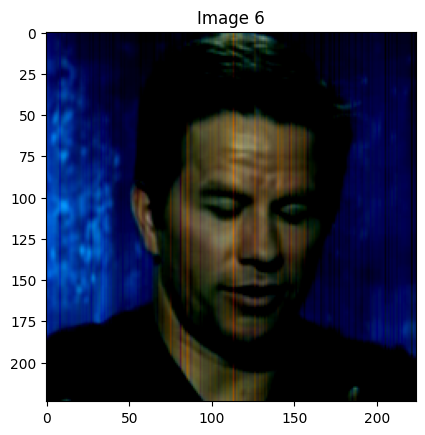

torch.Size([3, 224, 224])


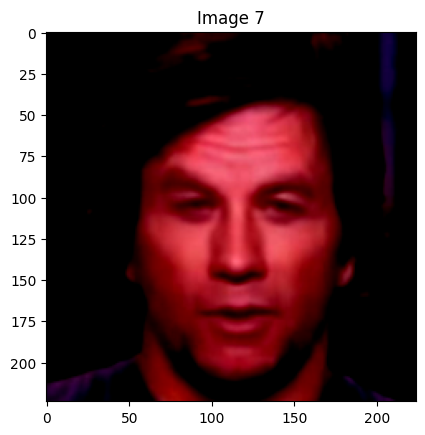

torch.Size([3, 224, 224])


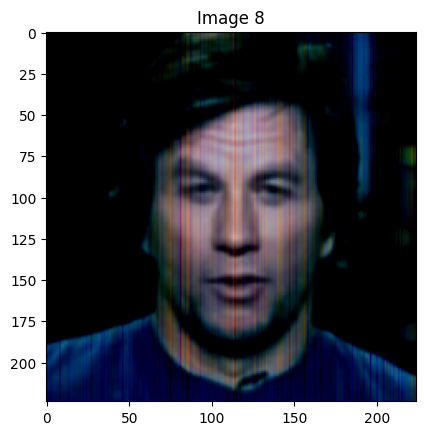

torch.Size([3, 224, 224])


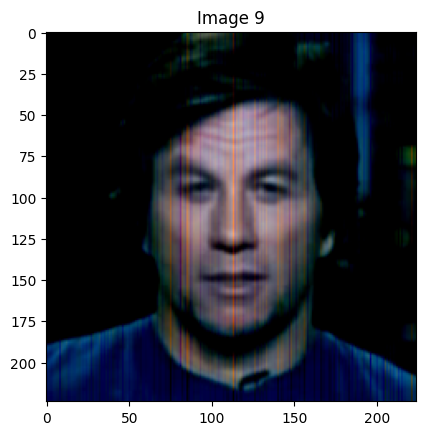

torch.Size([3, 224, 224])


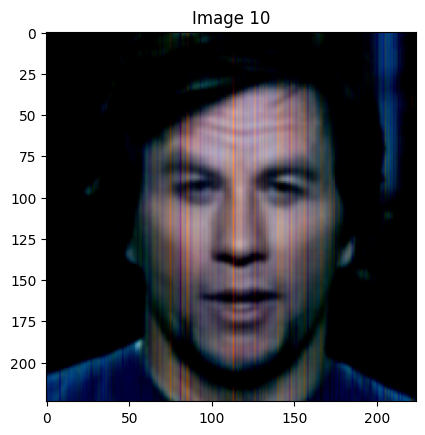

torch.Size([3, 224, 224])


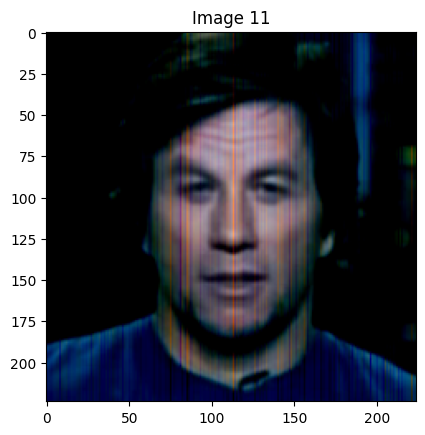

torch.Size([3, 224, 224])


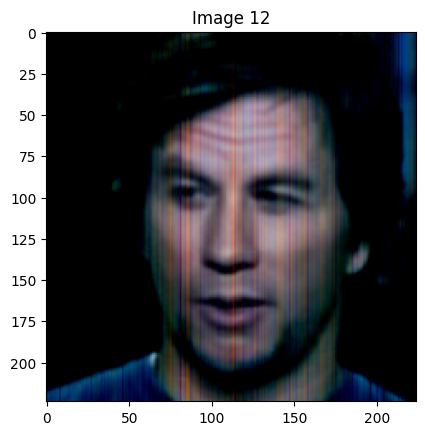

torch.Size([3, 224, 224])


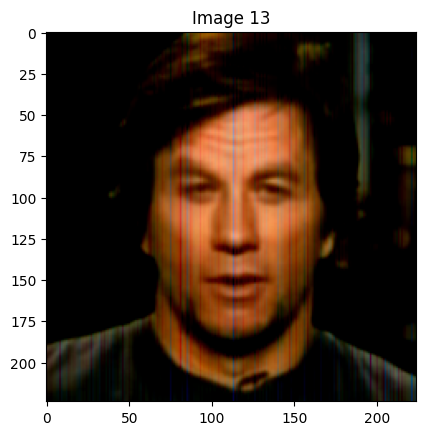

torch.Size([3, 224, 224])


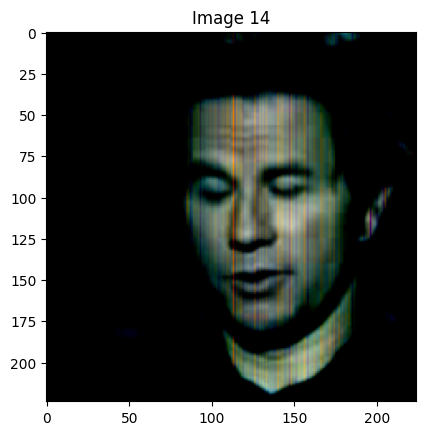

torch.Size([3, 224, 224])


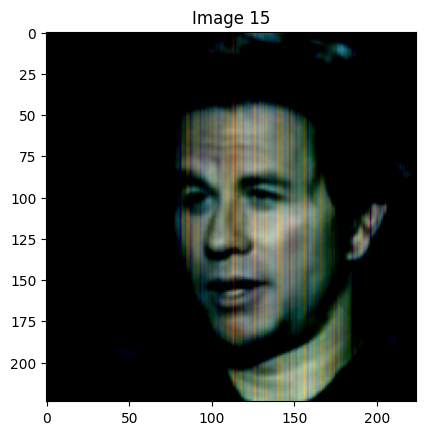

torch.Size([3, 224, 224])


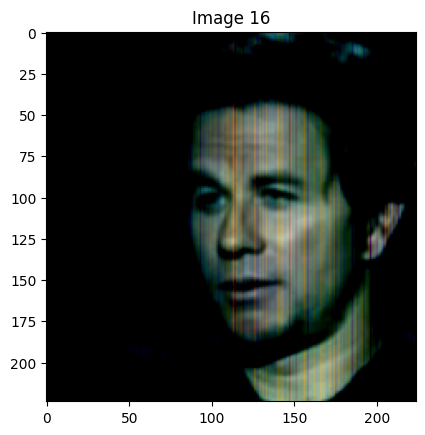

torch.Size([3, 224, 224])


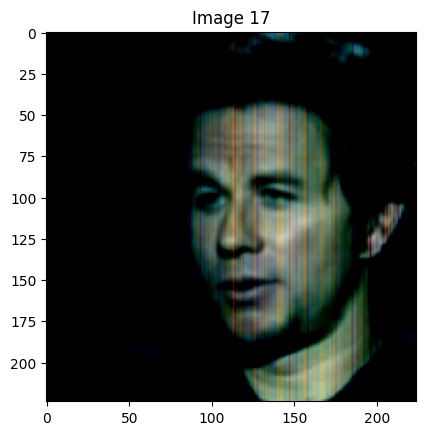

torch.Size([3, 224, 224])


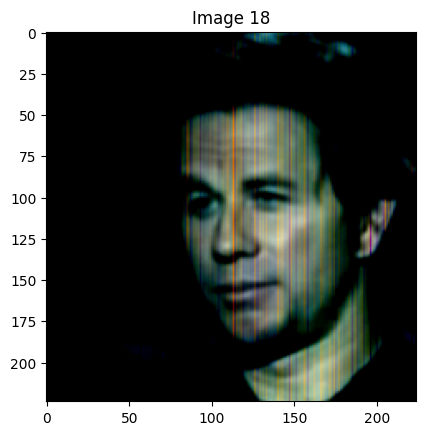

torch.Size([3, 224, 224])


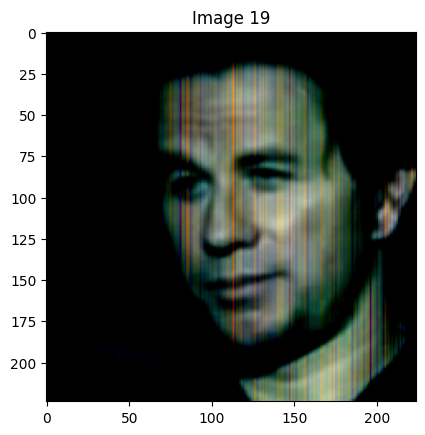

torch.Size([3, 224, 224])


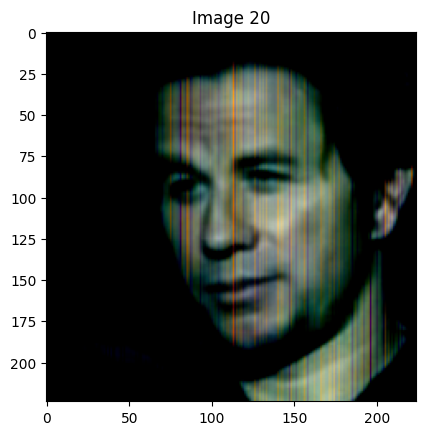

torch.Size([3, 224, 224])


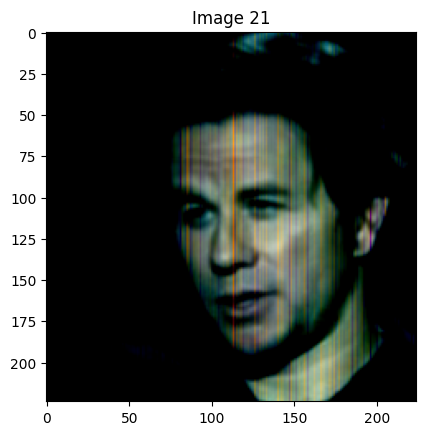

torch.Size([3, 224, 224])


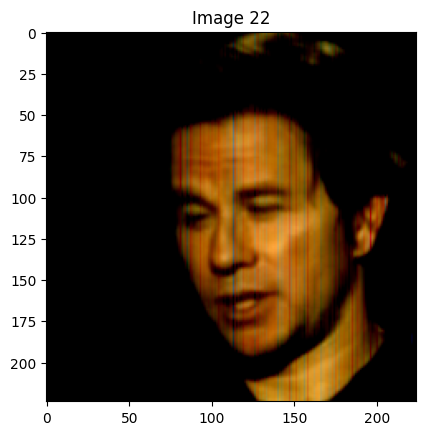

torch.Size([3, 224, 224])


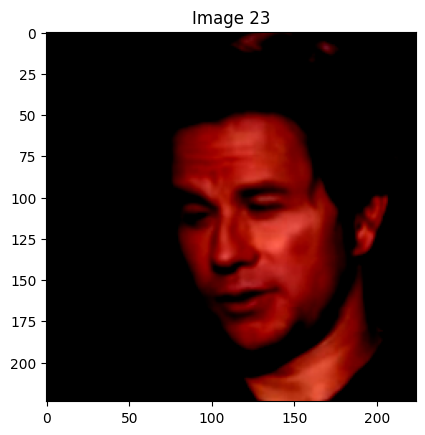

torch.Size([3, 224, 224])


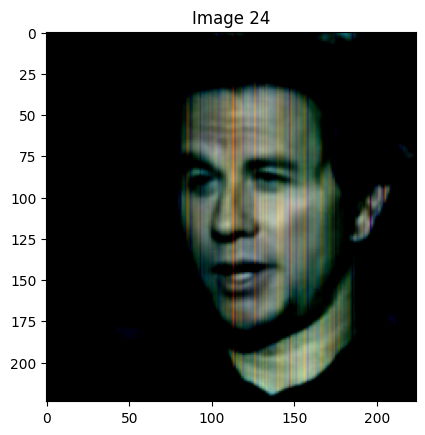

torch.Size([3, 224, 224])


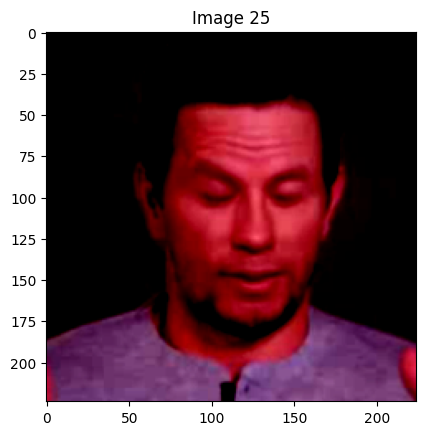

torch.Size([3, 224, 224])


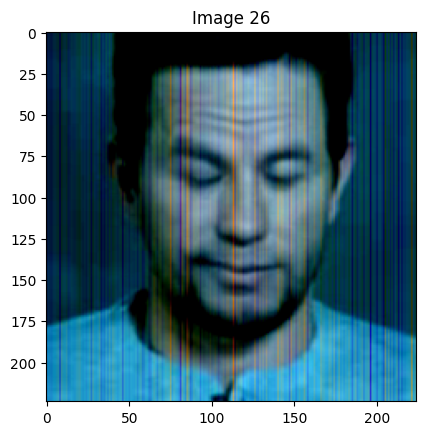

torch.Size([3, 224, 224])


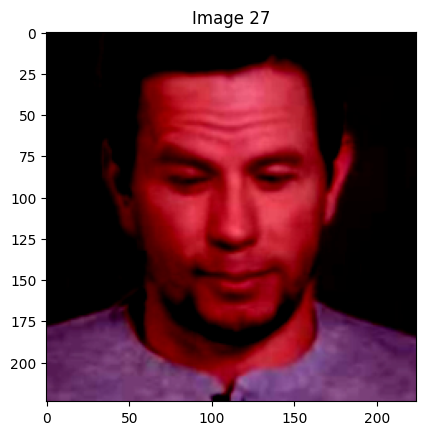

torch.Size([3, 224, 224])


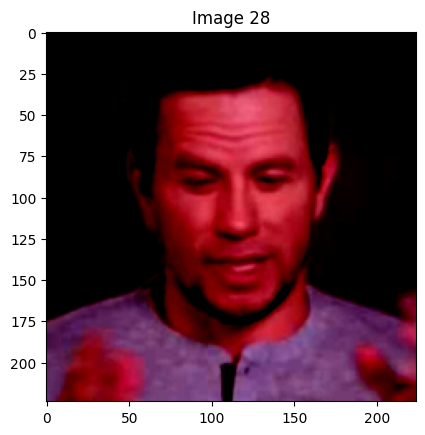

torch.Size([3, 224, 224])


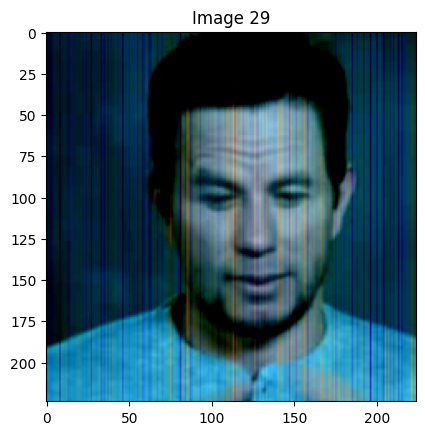

torch.Size([3, 224, 224])


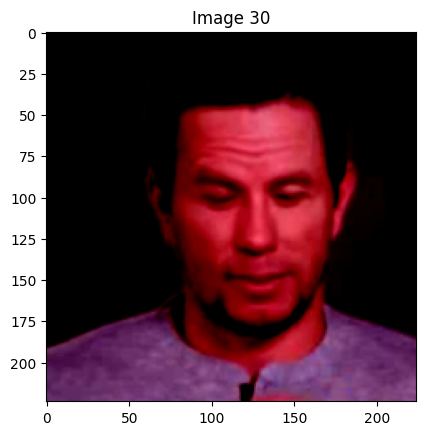

torch.Size([3, 224, 224])


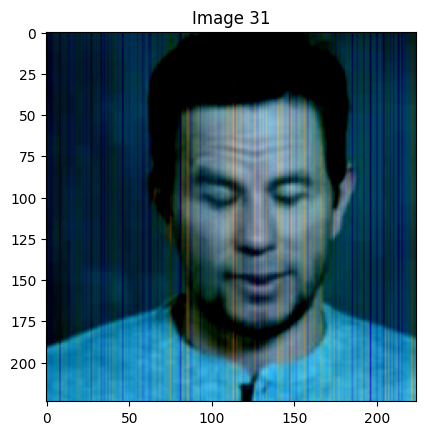

torch.Size([3, 224, 224])


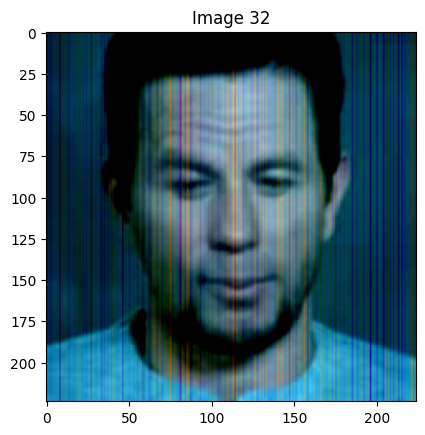

torch.Size([3, 224, 224])


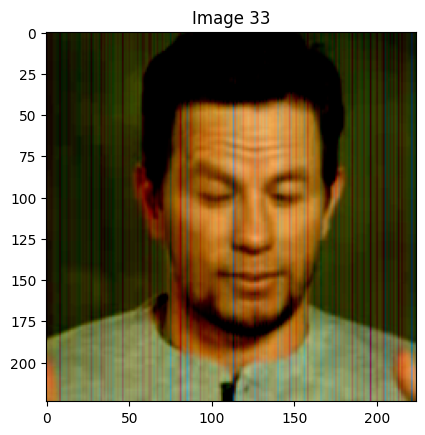

torch.Size([3, 224, 224])


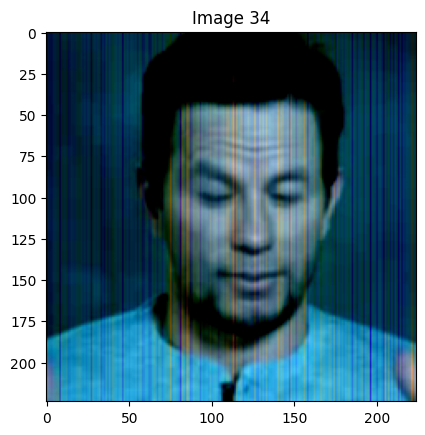

torch.Size([3, 224, 224])


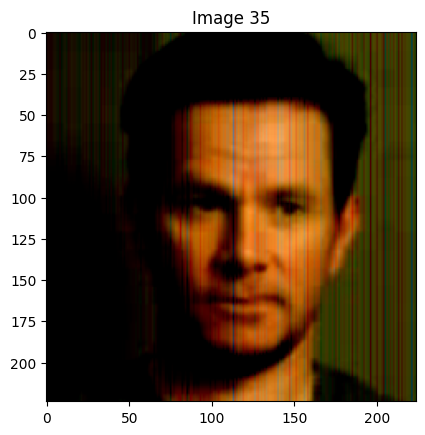

torch.Size([3, 224, 224])


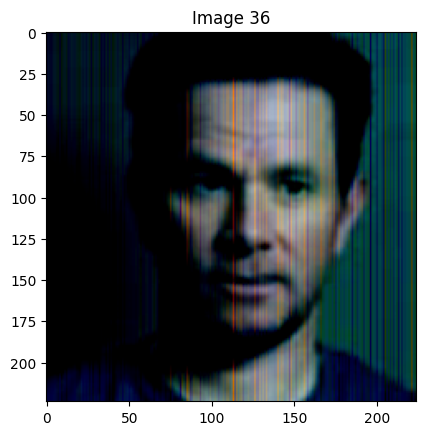

torch.Size([3, 224, 224])


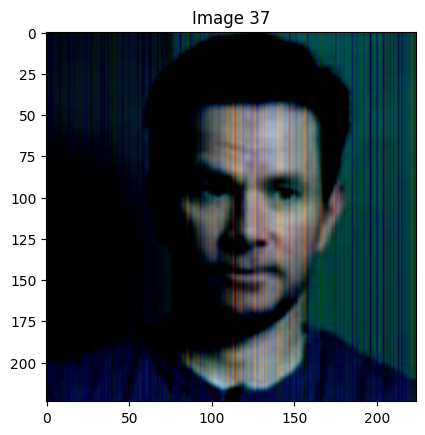

torch.Size([3, 224, 224])


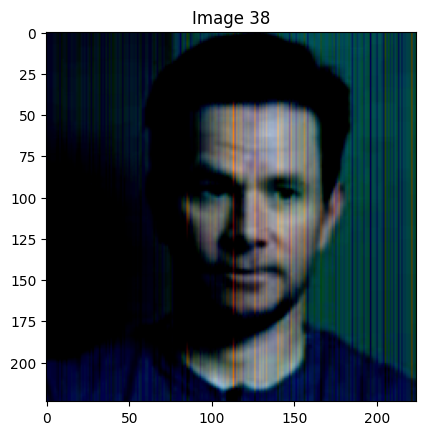

torch.Size([3, 224, 224])


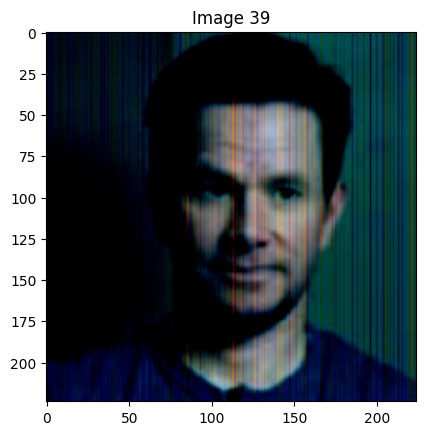

torch.Size([3, 224, 224])


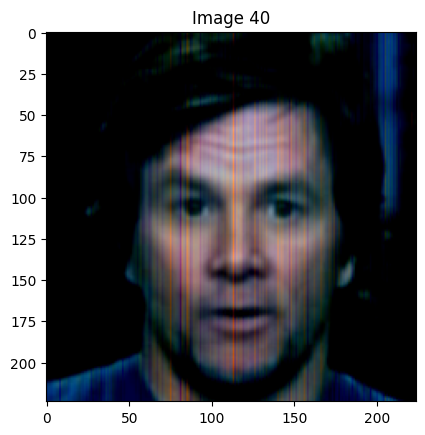

torch.Size([3, 224, 224])


KeyboardInterrupt: 

In [ ]:
from captum.attr import LayerGradCam, LayerAttribution
import cv2

def visualize_cam_on_image(image, cam_output):
    cam_output = cam_output.cpu().detach().numpy()
    cam_output = (cam_output - cam_output.min()) / (cam_output.max() - cam_output.min())  # Normalize

    cam_output = cv2.resize(cam_output, (image.shape[1], image.shape[2]))  # Reshape to input size
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image.permute(1, 2, 0).cpu().detach().numpy())
    cam_image = cam_image / np.max(cam_image)

    return cam_image

def generate_grad_cam(model, input_tensor, target_class=None):
    grad_cam = LayerGradCam(model, model.encoder.layers[-1])
    cam_output = grad_cam.attribute(input_tensor, target=target_class)

    return cam_output

test_dir = temp_dataset_root_dir + 'CELEB/val'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate Grad-CAM output for a batch of images
model.eval()
inputs, _ = next(iter(test_loader))  # Get a batch of validation images
inputs = inputs.to(device)

cam_output = generate_grad_cam(model, inputs, target_class = 0)
for i in range(inputs.size(0)):
    print(inputs[i].shape)
    cam_image = visualize_cam_on_image(inputs[i], cam_output[i])
    plt.imshow(cam_image)
    plt.title(f"Image {i+1}")
    plt.show()